# Using mpathic to compute footprints

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import sys
sys.path.insert(0, '/home/tom/mpathic')


In [15]:
from mpathic import learn_model

First we import a test data set.

In [16]:
df = pd.read_csv("../../../data/processed_barcodes/20221114_barcode/LB_by_promoter/araCp_counts.csv")
df.head(5)

,cDNA_count,gDNA_count,barcode,name,mapping_count,promoter
0,228337,38677,GGCCATACTTTTTGAAGTAT,araCp,39,GTCATGTAGCATCCGCTAATCTTATGGATAAAAATACTATGGCTTA...
1,79171,2461,CATACCTCATGGTGTGCGTA,araCp,3,GTCAGGTAGGATGCGCTAATCTTATGGATAAAAATGCTATGGCATA...
2,62180,23612,GTATATGTACGTCCCTGCGA,araCp,178,GTCAGCTAGGATCCGGTAATCTTATGGATAAAACTGCTCTGGCATA...
3,56594,38141,TAATTCATACTTCGGCGCAG,araCp,56,GTCTGGTAGGATCCGCTAATCTTATGGATATAAATGCTAGGGCATG...
4,55044,36067,CTTGAAAGGCTCTGTGCGTA,araCp,62,GTCATGTAGGAGCCCCTAATCTTAGGGATAAAAATGCTATGGCATA...


Prep dataframe to work with mpathic, therefore renaming columns and sorting the dataframe.

In [17]:
df.rename(
    columns={
        "cDNA_count": "ct_1",
        "gDNA_count": "ct_0",
        "promoter": "seq"
    },
    inplace=True
)
df['ct'] = df['ct_0'] + df['ct_1']
df = df[['ct', 'ct_0', 'ct_1', 'seq']]
df.head(5)

,ct,ct_0,ct_1,seq
0,267014,38677,228337,GTCATGTAGCATCCGCTAATCTTATGGATAAAAATACTATGGCTTA...
1,81632,2461,79171,GTCAGGTAGGATGCGCTAATCTTATGGATAAAAATGCTATGGCATA...
2,85792,23612,62180,GTCAGCTAGGATCCGGTAATCTTATGGATAAAACTGCTCTGGCATA...
3,94735,38141,56594,GTCTGGTAGGATCCGCTAATCTTATGGATATAAATGCTAGGGCATG...
4,91111,36067,55044,GTCATGTAGGAGCCCCTAATCTTAGGGATAAAAATGCTATGGCATA...


Run mpathic on dataframe.

In [ ]:
db = "../../../data/mpathic_footprints/20221114_barcode/araCp_LB_dataset_db"

mcmc_df = learn_model.main(
    df=df,
    lm='IM',
    modeltype='MAT',
    LS_means_std=None,
    db=db,
    iteration=300000,
    burnin=10000,
    thin=10,
    runnum=0,
    initialize='rand',
    start=0,
    end=None,
    foreground=1,
    background=0,
    alpha=0,
    pseudocounts=1,
    test=False,
    drop_library=False,
    verbose=True,
)


 [---               8%                  ] 25575 of 300000 complete in 3709.4 sec

In [ ]:
mcmc_df

,pos,val_A,val_C,val_G,val_T
0,0,0.044020,0.013355,0.020564,-0.077940
1,1,0.007296,0.033717,-0.016619,-0.024394
2,2,0.010933,-0.028751,-0.001826,0.019645
3,3,0.029397,-0.020677,-0.045234,0.036514
4,4,0.039015,-0.077516,0.027211,0.011289
...,...,...,...,...,...
155,155,0.012801,-0.019121,-0.032465,0.038785
156,156,0.012932,0.035863,0.002543,-0.051338
157,157,0.036668,0.017070,-0.019050,-0.034689
158,158,0.000197,0.002681,-0.002187,-0.000690


Transform phenotype output to probabilities using exponential distribution.

In [21]:
inf_arr = mcmc_df[['val_A', 'val_C', 'val_G', 'val_T']].to_numpy()
prob_mat = np.zeros((160, 4))

for i in range(160):
    prob_mat[i, :] = np.exp(inf_arr[i, :]) / np.sum(np.exp(inf_arr[i, :]))

Compute relative entropy.

In [22]:
relative_ent = np.zeros(160)
for i in range(160):
    relative_ent[i] = np.sum([prob_mat[i, j] * np.log2(prob_mat[i, j]/0.25) for j in range(4)])

Plot relative entropy footprint.

Text(0.5, 1.0, 'araC in LB')

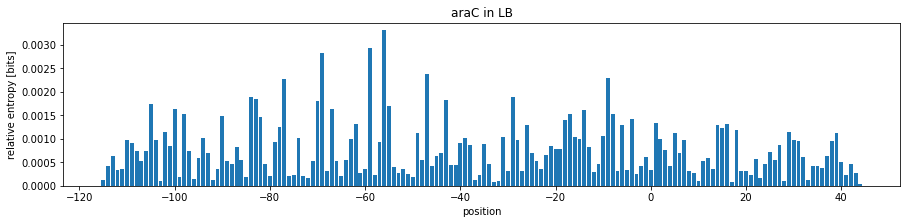

In [23]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.bar(np.arange(-115, 45), relative_ent)
ax.set_xlabel('position')
ax.set_ylabel('relative entropy [bits]')
ax.set_title('araC in LB')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.bar(np.arange(-115, 45), relative_ent)
ax.set_xlabel('position')
ax.set_ylabel('relative entropy [bits]')
ax.set_title('araC in LB')

## RegSeq dataset

In [77]:
df = pd.read_csv("../../../../RegSeq/data/sequencing_data/LB_data.csv", index_col=0)
df = df.loc[df['gene'] == 'ykgE', :]
df.rename(
    columns={
        'counts_RNA': 'ct_1',
        'counts_DNA': 'ct_0',
    },
    inplace=True
)
df['ct'] = df['ct_0'] + df['ct_1']
df = df[['ct', 'ct_0', 'ct_1', 'seq']]
df.dropna(inplace=True)
df.head(5)

,ct,ct_0,ct_1,seq
591,1141.0,726.0,415.0,TCGATTTCCCCAGAAGAAGGGAGCGAGGCCGAAAGAAATCAAATTA...
1526,234.0,109.0,125.0,TCGATTTCACCATAAAATGTCAGCGATGCCGAGAGAAATAAAATTA...
1543,107.0,97.0,10.0,CCGATTTCCCCATCAAATGTGAGCGGTGCCGGAAGAAATAAAATTA...
2173,87.0,77.0,10.0,TCGAGTTCCCCACAACATCTGAGCGATGCCCAAAGAAACAGAAATA...
3347,39.0,32.0,7.0,TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAAATA...


In [92]:
df = pd.read_csv("../../../../RegSeq/data/sequencing_data/ykgE_dataset_combined.csv")
df['seq'] = [x[0:160] for x in df['seq']]

In [93]:
mcmc_df = learn_model.main(
    df=df,
    lm='IM',
    modeltype='MAT',
    LS_means_std=None,
    db=db,
    iteration=300000,
    burnin=10000,
    thin=10,
    runnum=0,
    initialize='rand',
    start=0,
    end=None,
    foreground=1,
    background=0,
    alpha=0,
    pseudocounts=1,
    test=False,
    drop_library=False,
    verbose=False,
)


 [-----------------100%-----------------] 10000 of 10000 complete in 1294.2 sec

/home/tom/anaconda3/envs/mpathic_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tom/anaconda3/envs/mpathic_env/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


SortSeqError: 'Nonfinite parameters encountered.'

In [ ]:
inf_arr = mcmc_df[['val_A', 'val_C', 'val_G', 'val_T']].to_numpy()
prob_mat = np.zeros((160, 4))

for i in range(160):
    prob_mat[i, :] = np.exp(inf_arr[i, :]) / np.sum(np.exp(inf_arr[i, :]))

In [ ]:
relative_ent = np.zeros(160)
for i in range(160):
    relative_ent[i] = np.sum([prob_mat[i, j] * np.log2(prob_mat[i, j]/0.25) for j in range(4)])

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.bar(np.arange(-115, 45), relative_ent)
ax.set_xlabel('position')
ax.set_ylabel('relative entropy [bits]')
ax.set_title('ykgE in LB')

In [ ]:
pd.read_csv("../../../../RegSeq/data/sequencing_data/ykgE_dataset_combined.csv")

In [94]:
!mpathic learn-model --help

/bin/bash: mpathic: command not found


In [ ]:
z`